
# Model eigenvalues  

Eigenvalues are a fundamental concept in dynamic models. In simple terms, they summarize the adjustment process within a model. In the context of dynamic models, the sign and magnitude of the eigenvalues determine whether a system of equations will converge to a stable equilibrium, oscillate, or diverge. 

In the case of a macromodel, which is effectively a system of differential equations, the eigenvalues of the coefficient matrix determine whether the system is stable, marginally stable, or unstable. If all the eigenvalues have negative real parts, then the system is stable and will converge to a steady state over time. If at least one eigenvalue has a positive real part, then the system is unstable, and the solutions will diverge over time.


The modelflow library includes a range of methods to calculate the eigenvalues of a model, which can be used to help to assure that a model's dynamics will be stable and to identify sources of instability where they exist.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')


In [3]:
# Prepare the notebook for use of modelflow 

# Jupyter magic command to improve the display of charts in the Notebook
%matplotlib inline

# Import pandas 
import pandas as pd

# Import the model class from the modelclass module 
from modelclass import model 

# functions that improve rendering of modelflow outputs
model.widescreen()
model.scroll_off();

<IPython.core.display.Javascript object>

In [4]:
# Import to handle imaginary numbers 
import numpy as np 

# Import of modelflow lineraization methods. 
from modelnewton import newton_diff

## Load a model, data and descriptions 

For the purposes of this exposition the climate aware model for Pakistan described {cite:author}`burns_climate_2021` is used.

In [5]:
mpak,baseline = model.modelload('../models/pak.pcim')
baseline = mpak(baseline,2023,2100)

file read:  C:\modelflow manual\papers\mfbook\content\models\pak.pcim


:::{index} single: modelflow; .newtondiff() method
:::

:::{index} single: model derivatives
:::

:::{index} single: eigenvalues
:::

:::{index} single: modelflow; eigenvalues
:::
## the method .newton_diff()

The `modelflow` method `.newtondiff()` calculates the derivatives of the mpak model, and in the code block belows assigne the results to the object mpak_newton.


In [6]:
mpak_newton_long = newton_diff(mpak,forcenum=0)      # create a newton_diff instance which contains derivatives 

:::{index} single: eigenvalyues; .get_eigenvalues() method
:::
:::{index} single: modelflow; .get_eigenvalues() method
:::

### .get_eigenvalues method
The get_eigenvectors function calculates the actual eigenvectors of the model.  For a large model this can be a fairly time consuming calculation taking several minutes even on relatively powerful multicore i9 computers.

:::{index} single: modelflow; .get_eigplot_all() method
:::
:::{index} single: eqigenvalues; .get_eigplot_all() method
:::
Once the eigenvalues are calculated they can be displayed graphically with the `.eigplot_all()` method.

In [7]:
eig_dic = mpak_newton_long.get_eigenvectors(filnan = True,silent=False,asdf=1) #  

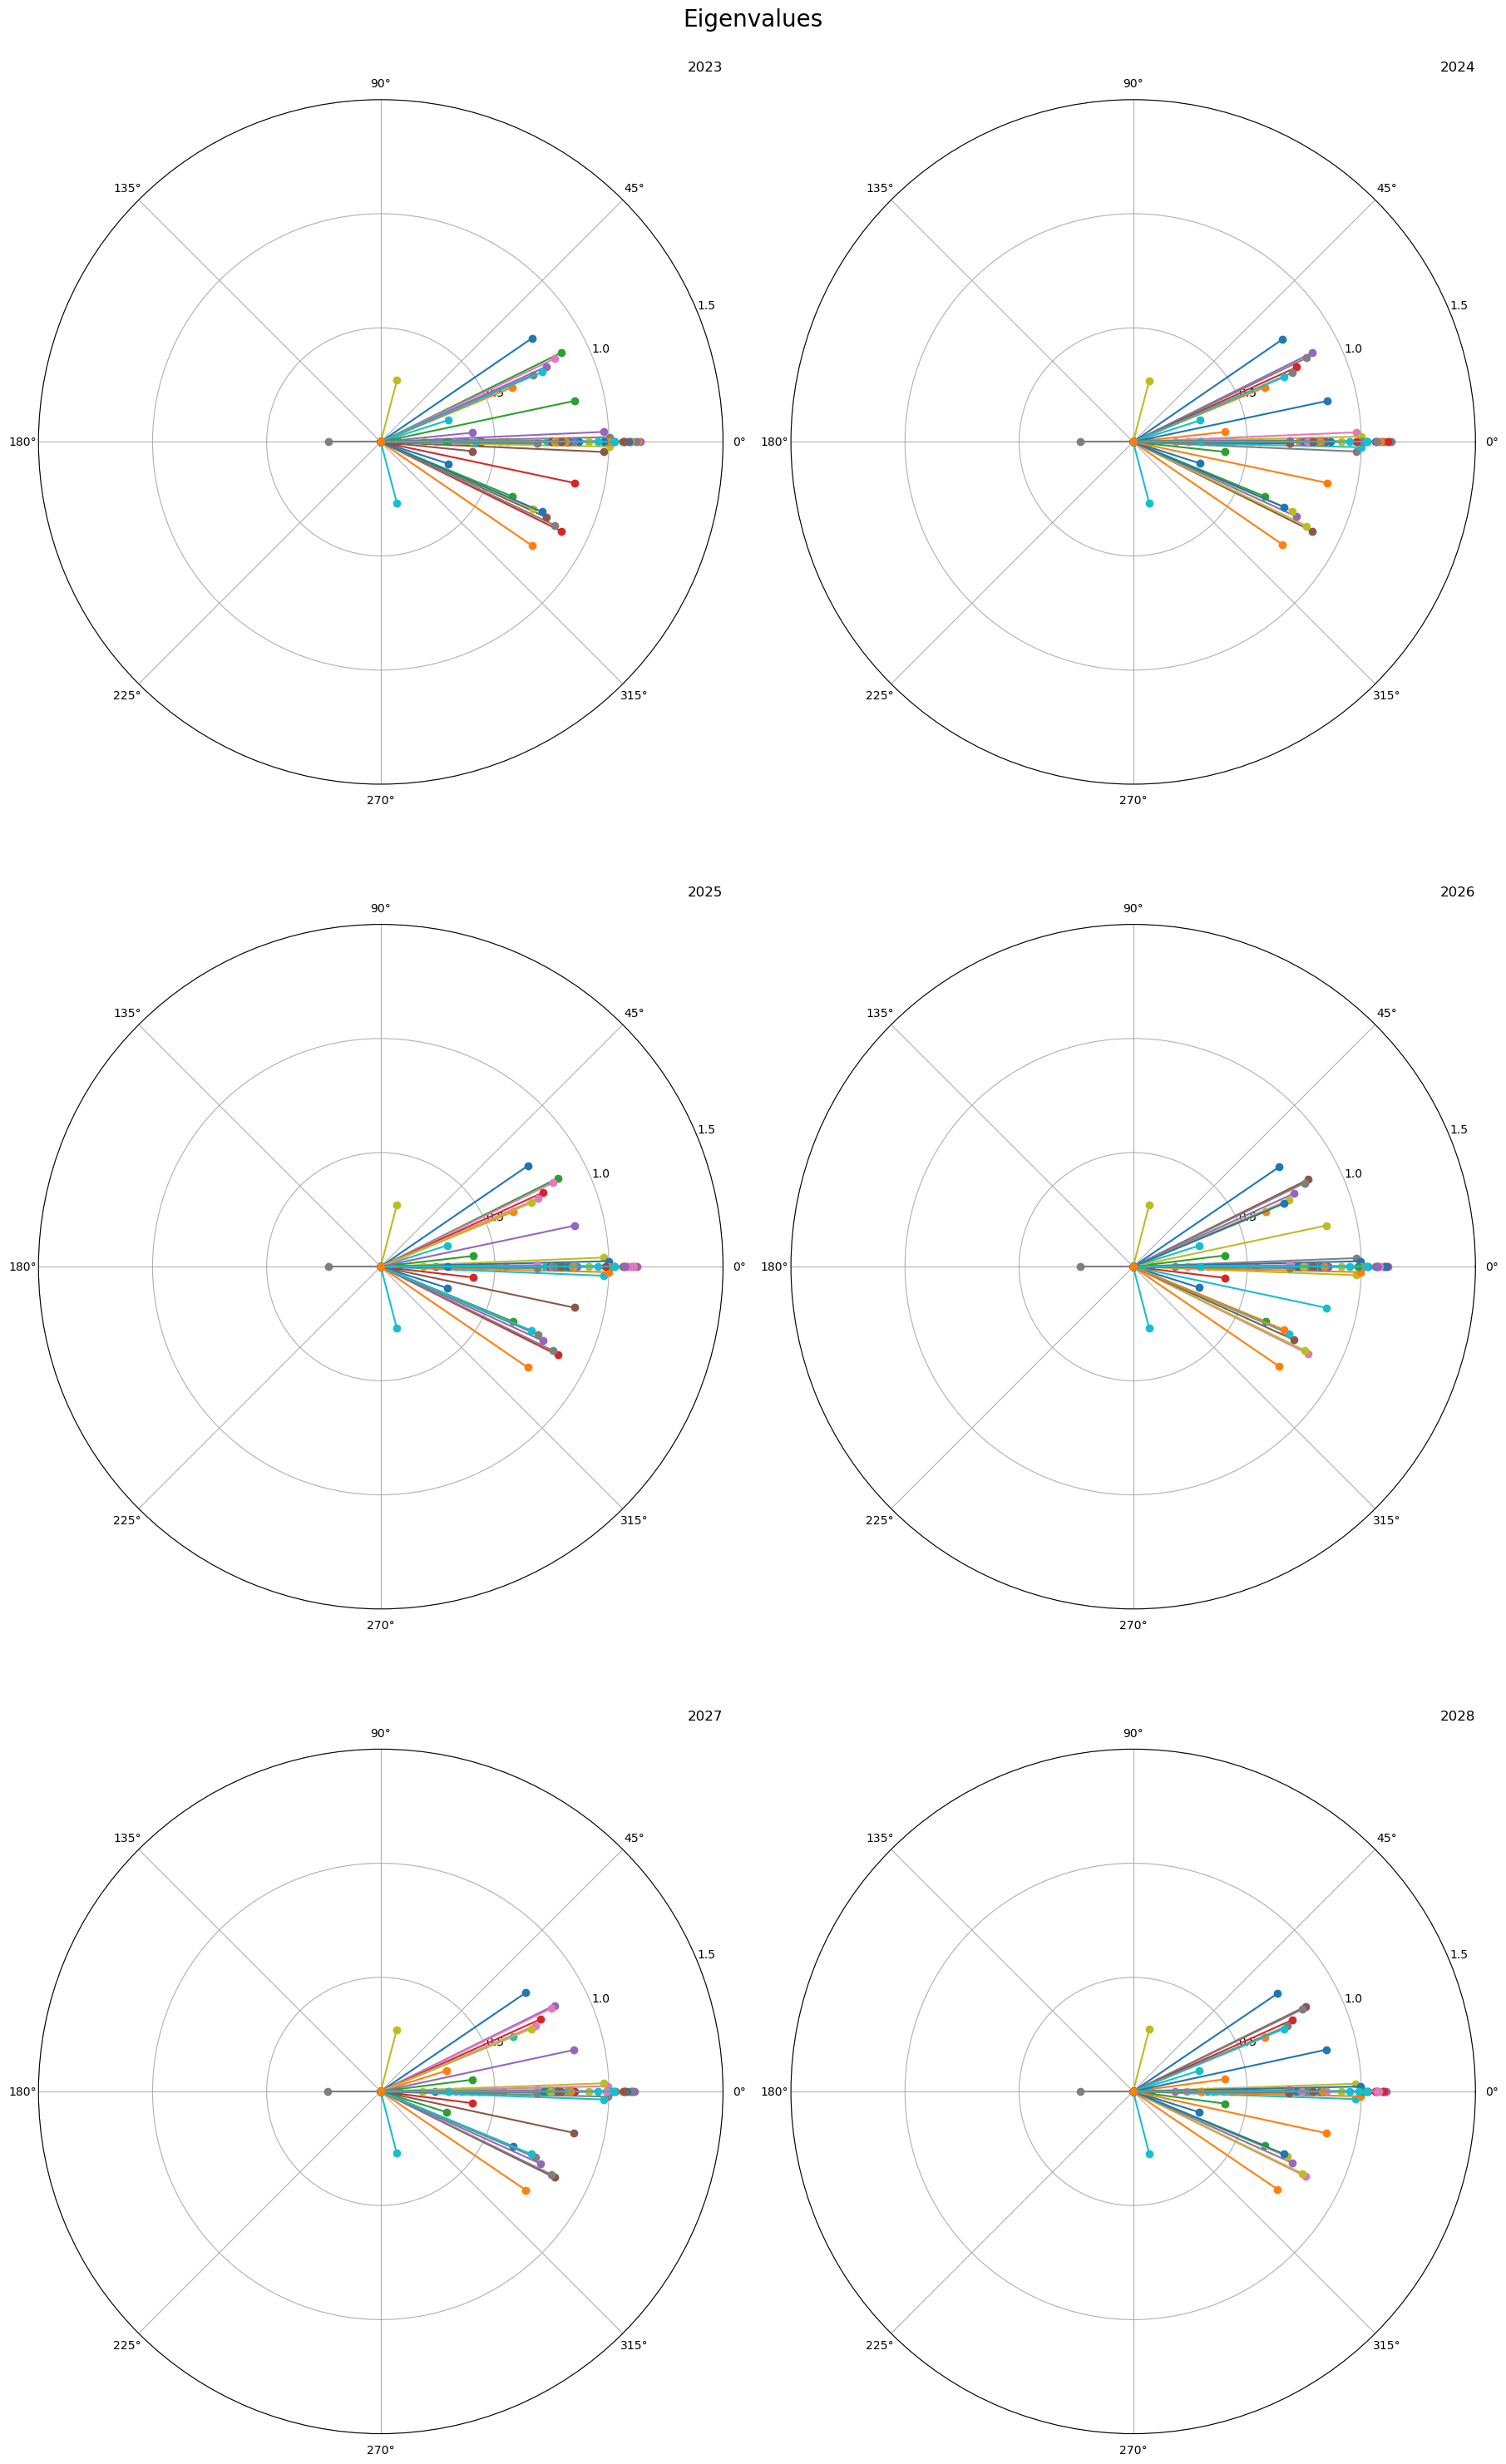

In [8]:
mpak_newton_long.eigplot_all(eig_dic,size=(1,1));

### Isolating potentially problematic eigenvalues

In the charts above it is clear that the vast majority of eigenvalues lie within the real unit circle, implying that the associated equations are dynamically stable.  However, there are several that lie outside of the unit circle.

The code below identifies and prints out those elements that are greater than one in 2023.

In [9]:
eigen = eig_dic[2023]
gt1_no_imag = sorted([(ii,i)  for ii,i in enumerate(eigen) if abs(i) >= 1 and abs(i.imag) < 0.0000000001],reverse=True)
gt1_imag    = sorted([(ii,i)  for ii,i in enumerate(eigen) if np.abs(i) >= 1 and np.abs(i.imag) >  0.00000001],reverse=True)

print('Eigenvalues with length above 1 and only real: ')
print(*[f'element {ii} length: {abs(i):.5f} ' for ii,i in gt1_no_imag],'  ',sep='\n')
print('Eigenvalues with length above 1 and imaginary: ')
print(*[f'element {ii} length: {abs(i):.5f} {i.real:.5f} {i.imag:.5f}' for ii,i in gt1_imag],sep='\n')



Eigenvalues with length above 1 and only real: 
element 1499 length: 1.02441 
element 1419 length: 1.02000 
element 1331 length: 1.00000 
element 1325 length: 1.06952 
element 1324 length: 1.06998 
element 1323 length: 1.06368 
element 1322 length: 1.06036 
element 1321 length: 1.00287 
element 1320 length: 1.08554 
element 1311 length: 1.09349 
element 1307 length: 1.12010 
element 1301 length: 1.12521 
element 535 length: 1.00816 
element 495 length: 1.02299 
element 494 length: 1.13663 
element 456 length: 1.09513 
element 455 length: 1.09868 
  
Eigenvalues with length above 1 and imaginary: 
element 1318 length: 1.00303 1.00282 -0.02084
element 1317 length: 1.00303 1.00282 0.02084


These results that 16 eigenvalues exceed 1 and that two exceed one and have imaginary roots.

### Look at all years 
In each year find eigenvalues outside the unit circle and divide them into two parts one with real values and with imaginary values. 

In [10]:
def print_eigenvalues_summary(eig_dic, print_all=False):
    """
    Prints a summary of eigenvalues with length > 1 

    Args:
    eig_dic (dict): A dictionary where keys are years and values are lists of eigenvalues.
    print_all (bool): If True, prints all years. If False, only prints years with non-zero imaginary eigenvalues.

    Returns:
    None
    """
    length_dict = {year: 
        {'lgt1_no_imag': len([i for i in eigen if abs(i) >= 1 and abs(i.imag) < 0.0000000001]),
         'gt1_imag': len([i for i in eigen if abs(i) >= 1 and i.imag > 0.00000001])} 
        for year, eigen in eig_dic.items()
    }

    print('Eigenvalues with length >= 1')
    for year, res in length_dict.items():
        if print_all or res["gt1_imag"] != 0:
            real_values = res["lgt1_no_imag"]
            imag_values = res["gt1_imag"] if res["gt1_imag"] != 0 else ""
            print(f'{year} With real values {real_values}, with imaginary values {imag_values}')


print_eigenvalues_summary(eig_dic, print_all=False)


Eigenvalues with length >= 1
2023 With real values 17, with imaginary values 1
2031 With real values 14, with imaginary values 1
2053 With real values 15, with imaginary values 1
2054 With real values 15, with imaginary values 1
2055 With real values 15, with imaginary values 1
2056 With real values 15, with imaginary values 1
2057 With real values 15, with imaginary values 1
2058 With real values 16, with imaginary values 1
2059 With real values 15, with imaginary values 1
2062 With real values 17, with imaginary values 1
2063 With real values 17, with imaginary values 1
2064 With real values 17, with imaginary values 1
2094 With real values 16, with imaginary values 1
2096 With real values 17, with imaginary values 1
2097 With real values 17, with imaginary values 1
2099 With real values 17, with imaginary values 1


## Dealing with potential instability

Unfortunately there is no one-to-one relationship between equations and eigenvalues. It may be that certain equations are inherently unstable, error-correction models where the speed of adjustment is greater than one for example.  Equation results can be inspected for such sources of instability.  

Other sources of instability may be more subtle and lie in the interaction of coefficients across equations.  One approach to identifying potentially problematic equations is to perform a grid-search by recalculating the eigenvalues of the system after eliminating one at a time individual equations. The elimination of an ill-formed equation is likely to cause large and greater than one eigenvalues to shrink and potentially even fall within the unit circle.

:::{index} single: stability; .get_eigen_jackknife_df() method
:::
:::{index} single: eigenvalues; .get_eigen_jackknife_df() method
:::
:::{index} single: modelflow; .get_eigen_jackknife_df() method
:::


### The `.get_eigen_jackknife_df()` method

Modelflow includes a jackknife algorithm (`.get_eigen_jackknife_df()`) that systematically drops one-by-one each equation from model, and then recalculates the eigenvalues of the smaller model. The  eigenvalues for each new model are returned as a tall dataframe. 

By keeping track of the size of the largest eigenvalues, it seeks to identify one (or more) equations that have a large influence on the eigenvalues of the system.

For a large model, this can be a time-consuming exercise (7-12 minutes for mpak in two years, depending on the user's processor).


a tall dataframe with the following columns is returned

| Column     | Explanation                                         |
|:-----------|:-----------------------------------------------------|
| excluded   | The name or identifier of the excluded variable.    |
| year       | The year associated with the data row.              |
| index      | The index or position of the row in the dataset.    |
| value      | The computed or observed value for the row.         |
| length     | The absolute length or magnitude of the `value`.    |
| realvalue  | The real part of the `value` if it's complex.       |
| imagvalue  | The imaginary part of the `value` if it's complex.  |
|excluded_description| The description of the variable for which the equation is excluded|




To test code, the parameter maxnames can be set to restrict the number of re-samplings.

The routine sums the 20 largest eigenvalues each time an equation is omitted.  Equations whose omission from the model reduces the largest eigenvalues the most are most likely to be the source of model instability.


### Look at only 2 years
For the sake of execution time a new mpak_newton is created with only 2 years. 

In [11]:
_ = mpak(baseline,2023,2024)
mpak_newton = newton_diff(mpak,forcenum=0)      # create a newton_diff instance which contains derivatives 
# eig_dic_short = mpak_newton.get_eigenvectors(filnan = True,silent=False,asdf=1) #  

In [12]:
jackdf  = mpak_newton.get_eigen_jackknife_df()

Calculating eigenvalues of 303  different matrices takes time, so make cup of coffee and a take a short nap


  0%|          | 0/303 [00:00<?, ?it/s]

### The structure of jackdf

In [13]:
jackdf.head()

excluded  year  index     value  length  realvalue  imagvalue  \
0     NONE  2023      0  0.0+0.0j     0.0        0.0        0.0   
1     NONE  2023      1  0.0+0.0j     0.0        0.0        0.0   
2     NONE  2023      2  0.0+0.0j     0.0        0.0        0.0   
3     NONE  2023      3  0.0+0.0j     0.0        0.0        0.0   
4     NONE  2023      4  0.0+0.0j     0.0        0.0        0.0   

  excluded_description  
0          whole model  
1          whole model  
2          whole model  
3          whole model  
4          whole model

## One eigenvalue with length > 1 and imaginary value different from 0. 
As wanted the result with all equations are the same as above. Remember imaginary values always comes in pairs. A positive and a negative number. 

In [14]:
jackdf.query('excluded =="NONE" & length > 1 & abs(imagvalue) != 0.0 &  year == 2023')

excluded  year  index               value    length  realvalue  \
1317     NONE  2023   1317  1.002818+0.020851j  1.003034   1.002818   
1318     NONE  2023   1318  1.002818-0.020851j  1.003034   1.002818   

      imagvalue excluded_description  
1317   0.020851          whole model  
1318  -0.020851          whole model

##  Which equations can be deleted, and there will still be a length > 1 and imaginary value different from 0. 
Apparently for  285 equations the model is still unstable if the equations is deleted.  

In [15]:
jackdf.query('length > 1 & imagvalue > 0.0 &  year == 2023')

excluded  year  index               value    length  realvalue  \
1317            NONE  2023   1317  1.002818+0.020851j  1.003034   1.002818   
4344        CHNEXR05  2023   1320  1.002818+0.020851j  1.003034   1.002818   
7360      CHNPCEXN05  2023   1320  1.002818+0.020851j  1.003034   1.002818   
10376       DEUEXR05  2023   1320  1.002818+0.020851j  1.003034   1.002818   
13392     DEUPCEXN05  2023   1320  1.002818+0.020851j  1.003034   1.002818   
...              ...   ...    ...                 ...       ...        ...   
903109  PAKWHSLINTKN  2023   1317  1.002818+0.020851j  1.003034   1.002818   
906114       PAKXMKT  2023   1306  1.002818+0.020851j  1.003034   1.002818   
909130    PAKXMKT_GR  2023   1306  1.002818+0.020851j  1.003034   1.002818   
912146      TUREXR05  2023   1306  1.002818+0.020851j  1.003034   1.002818   
915162    TURPCEXN05  2023   1306  1.002818+0.020851j  1.003034   1.002818   

        imagvalue                     excluded_description  
1317     0.020851                              whole model  
4344     0.020851                                 CHNEXR05  
7360     0.020851                               CHNPCEXN05  
10376    0.020851                                 DEUEXR05  
13392    0.020851                               DEUPCEXN05  
...           ...                                      ...  
903109   0.020851                             PAKWHSLINTKN  
906114   0.020851  PAKXMKT Weighted Trading Partner Demand  
909130   0.020851                               PAKXMKT_GR  
912146   0.020851                                 TUREXR05  
915162   0.020851                               TURPCEXN05  

[287 rows x 8 columns]

## Now find the equations which - if deleted - will cause the no eigenvalues with a length > 1 and imaginary value different from 0.'
This could point to a potential problem with the equation. 

Here the groupby and filter property of pandas dataframes is used to identify which equations - when deleted - causes the model not to induce exploding oscillation. 

In [16]:
def get_unique_excluded(df, year, excluded_col='excluded', description_col='excluded_description'):
    """
    Filters the DataFrame for a specific year and returns unique values of 'excluded' and their descriptions,
    where no row in the group satisfies both conditions (length > 1 and imagvalue > 0).

    Args:
    df (pandas.DataFrame): The DataFrame to process.
    year (int): The year to filter the DataFrame.
    excluded_col (str): The name of the column containing excluded variables. Default is 'excluded'.
    description_col (str): The name of the column containing descriptions of excluded variables. Default is 'excluded_description'.

    Returns:
    tuple: A tuple containing two arrays - unique excluded descriptions and unique excluded variables.
    """
    # Filter DataFrame for the specified year and apply the conditions
    filtered_df = df.query('year == @year').groupby(excluded_col).filter(
        lambda x: ~((x['length'] > 1) & (x['imagvalue'] > 0)).any()
    )

    # Extract unique values
    unique_descriptions = filtered_df[description_col].unique()
    unique_variables = filtered_df[excluded_col].unique()

    return unique_descriptions, unique_variables

unique_excluded_descriptions, unique_excluded_variables = get_unique_excluded(jackdf, 2023)
print(unique_excluded_descriptions)


['PAKGGDBTTOTLCN General government gross debt millions lcu'
 'PAKGGEXPCAPTCN General government expenditure on capital expenditure (millions lcu)'
 'PAKGGEXPINTPCN General government interest payments on public debt (millions lcu)'
 'PAKGGREVTOTLCN General government revenues, total (millions lcu)'
 'PAKNECONGOVTCN Govt. Cons., LCU mn' 'PAKNECONGOVTKN Gov. Cons real'
 'PAKNECONOTHRXN' 'PAKNECONPRVTCN Pvt. Cons., LCU mn'
 'PAKNECONPRVTXN Implicit LCU defl., Pvt. Cons., 2000 = 1'
 'PAKNEGDIFPRVKN Prvt. Investment real' 'PAKNEGDIFTOTKN Investment real'
 'PAKNEGDIFTOTKN2' 'PAKNEGDIKSTKKN Capital stock, LCU'
 'PAKNYGDPFCSTXN GDP Factor Cost Local Currency units Implicit Price deflator'
 'PAKNYGDPGAP_ Output Gap (% of Potential GDP)'
 'PAKNYGDPMKTPCN GDP, Market Prices, LCU mn'
 'PAKNYGDPPOTLKN Potential Output, constant LCU']


## Show the eviews equations for the equations. 

In [17]:
string_of_excluded_variables = ' '.join(unique_excluded_variables)
mpak[string_of_excluded_variables].eviews

PAKGGDBTTOTLCN  : PAKGGDBTTOTLCN = PAKGGDBTTOTLCN( - 1) - PAKGGBALOVRLCN + PAKGGDBTVALTCN + 0*DUMH
PAKGGEXPCAPTCN  : PAKGGEXPCAPTCN = 0.3*PAKGGEXPCAPTCN( - 1) + (1 - 0.3)*(0.37*(PAKGGREVTOTLCN - PAKGGEXPINTPCN( - 0))) + 393385.011*@DURING("2013")
PAKGGEXPINTPCN  : @IDENTITY PAKggexpintpcn  = PAKggexpintecn  + PAKggexpintdcn
PAKGGREVTOTLCN  : @IDENTITY PAKGGREVTOTLCN  = (PAKGGREVOTHRCN  + PAKGGREVDRCTCN  + PAKGGREVGRNTCN  + PAKGGREVGNFSCN  + PAKGGREVTRDECN  + PAKGGREVEMISCN)  + (PAKinsu  + PAKcofu)  * PAKPAYOUTCN
PAKNECONGOVTCN  : @PC(PAKNECONGOVTCN) = @PC(PAKGGEXPGNFSCN) + 0.764199817873939*DUMH
PAKNECONGOVTKN  : @IDENTITY PAKNEcongovtkn  = PAKNEcongovtcn  / PAKNEcongovtxn
PAKNECONOTHRXN  : DLOG(PAKNECONOTHRXN) = 0.590372627657176*DLOG(PAKNYGDPFCSTXN) + D(PAKGGREVGNFSXN/100) + (1 - 0.590372627657176)*DLOG(PAKNEIMPGNFSXN) + 0.2*PAKNYGDPGAP_/100
PAKNECONPRVTCN  : @IDENTITY PAKNECONPRVTCN  = PAKNECONPRVTKN  * PAKNECONPRVTXN
PAKNECONPRVTXN  : @IDENTITY PAKNECONPRVTXN  = ((PAKNECONENGYSH^PA

## Show the modelflow equations. 

In [18]:
mpak[string_of_excluded_variables].frml

PAKGGDBTTOTLCN  : FRML <DAMP,STOC> PAKGGDBTTOTLCN = (PAKGGDBTTOTLCN(-1)-PAKGGBALOVRLCN+PAKGGDBTVALTCN+0*DUMH + PAKGGDBTTOTLCN_A)* (1-PAKGGDBTTOTLCN_D)+ PAKGGDBTTOTLCN_X*PAKGGDBTTOTLCN_D $
PAKGGEXPCAPTCN  : FRML <DAMP,STOC> PAKGGEXPCAPTCN = (0.3*PAKGGEXPCAPTCN(-1)+(1-0.3)*(0.37*(PAKGGREVTOTLCN-PAKGGEXPINTPCN(-0)))+393385.011*DURING_2013 + PAKGGEXPCAPTCN_A)* (1-PAKGGEXPCAPTCN_D)+ PAKGGEXPCAPTCN_X*PAKGGEXPCAPTCN_D $
PAKGGEXPINTPCN  : FRML <IDENT> PAKGGEXPINTPCN = PAKGGEXPINTECN+PAKGGEXPINTDCN $
PAKGGREVTOTLCN  : FRML <IDENT> PAKGGREVTOTLCN = (PAKGGREVOTHRCN+PAKGGREVDRCTCN+PAKGGREVGRNTCN+PAKGGREVGNFSCN+PAKGGREVTRDECN+PAKGGREVEMISCN)+(PAKINSU+PAKCOFU)*PAKPAYOUTCN $
PAKNECONGOVTCN  : FRML <DAMP,STOC> PAKNECONGOVTCN = (PAKNECONGOVTCN_A*PAKNECONGOVTCN(-1)/100+ ((100 * ( (PAKGGEXPGNFSCN) / (PAKGGEXPGNFSCN(-1)) -1)) +0.764199817873939*DUMH) *PAKNECONGOVTCN(-1)/100+PAKNECONGOVTCN(-1)) * (1-PAKNECONGOVTCN_D)+ PAKNECONGOVTCN_X*PAKNECONGOVTCN_D $
PAKNECONGOVTKN  : FRML <IDENT> PAKNECONGOVTKN = PAKNE